# Trénovanie modelu iba na základe DST indexu 1h dopredu 6 dozadu
Súbor: 1_dopredu_6_dozadu.ipynb

Program: Hospodárska informatika

Vypracovala: Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 29.4 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 511.7 MB 43 kB/s s eta 0:00:01
     |████████████████████████████████| 123 kB 58.0 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 61.0 MB/s eta 0:00:01
     |████████████████████████████████| 17.1 MB 72.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 67.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 77.2 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 77.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 44.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.11.0
    Uninstalling absl-py-0.11.0:
      Successfully uninstalled absl-py-0.11

### Kontrola kapacity servera

In [2]:
!nvidia-smi

Sun May 29 19:28:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:01:00.0 Off |                    0 |
| 23%   34C    P8    23W / 235W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [23]:
df = pd.read_csv('omni_full.csv')
len(df)

520443

In [24]:
df.columns

Index(['Unnamed: 0', 'time1', 'Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS',
       'ABS_B', 'F', 'THETA_AV', 'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE',
       'BY_GSM', 'BZ_GSM', 'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By',
       'SIGMA$Bz', 'T', 'N', 'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure',
       'SIGMA$T', 'SIGMA$N', 'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V',
       'SIGMA$ratio', 'E', 'Beta', 'Mach_num', 'Mgs_mach_num', 'PR$FLX_1',
       'PR$FLX_2', 'PR$FLX_4', 'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX',
       'R', 'F10_INDEX', 'KP', 'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX',
       'PC_N_INDEX', 'Solar_Lyman_alpha', 'Proton_QI', 'DST+1', 'DST+2',
       'DST+3', 'DST+4', 'DST+6', 'DST+8', 'DST+12', 'DST+24'],
      dtype='object')

In [25]:
features = ['time1',
           'DST',
            'DST+1']

In [26]:
df = df[features]

In [27]:
df['time1']=pd.to_datetime(df['time1'])

In [28]:
df.dropna(inplace=True)
print(len(df))

520442


In [29]:
predicted_label = 'DST+1'

In [30]:
df.describe()

,DST,DST+1
count,520442.000000,520442.000000
mean,-14.125032,-14.125049
std,22.034851,22.034840
min,-589.000000,-589.000000
25%,-22.000000,-22.000000
50%,-10.000000,-10.000000
75%,-1.000000,-1.000000
max,81.000000,81.000000


In [11]:
df[predicted_label].describe()

count    520442.000000
mean        -14.125049
std          22.034840
min        -589.000000
25%         -22.000000
50%         -10.000000
75%          -1.000000
max          81.000000
Name: DST+1, dtype: float64

In [12]:
df.head()

,time1,DST+1
1,1963-01-01 02:00:00,-5.0
2,1963-01-01 03:00:00,-5.0
3,1963-01-01 04:00:00,-3.0
4,1963-01-01 05:00:00,-3.0
5,1963-01-01 06:00:00,-6.0


<AxesSubplot:>

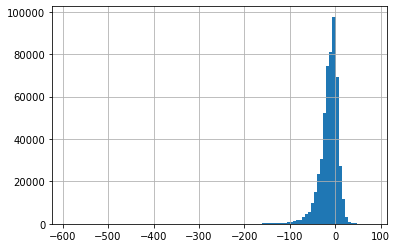

In [15]:
df[predicted_label].hist(bins=100)

In [109]:
# transform label using sigmoid
variance = df[predicted_label].std()
df["contcontinuous_transforminuous_transform"] = df[predicted_label].apply(lambda x: expit(2 * ((x - 0.2) / variance)))
df["contcontinuous_transforminuous_transform"].describe()

count    8.636300e+04
mean     3.210852e-01
std      2.380039e-01
min      6.049032e-14
25%      1.197698e-01
50%      2.918339e-01
75%      4.938441e-01
max      9.999218e-01
Name: contcontinuous_transforminuous_transform, dtype: float64

In [31]:
# choose one of them
# define y variable, i.e., what we want to predict

y_col='DST+1'
#y_col='contcontinuous_transforminuous_transform'

In [32]:
# train-test division

test_size = int(len(df) * 0.2) # here I ask that the test data will be 20% of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [33]:
# train-validation division

valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [34]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()

y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [35]:
print(y_test[0:40])

[-13. -13. -12. -12. -17. -17. -15. -11.  -8. -12. -16. -14. -14. -14.
 -15. -17. -13. -15. -24. -21. -17. -15. -17. -25. -27. -26. -27. -27.
 -25. -26. -20. -16. -14. -14. -16. -16. -15. -13. -10. -15.]


In [57]:
len(y_test)

104088

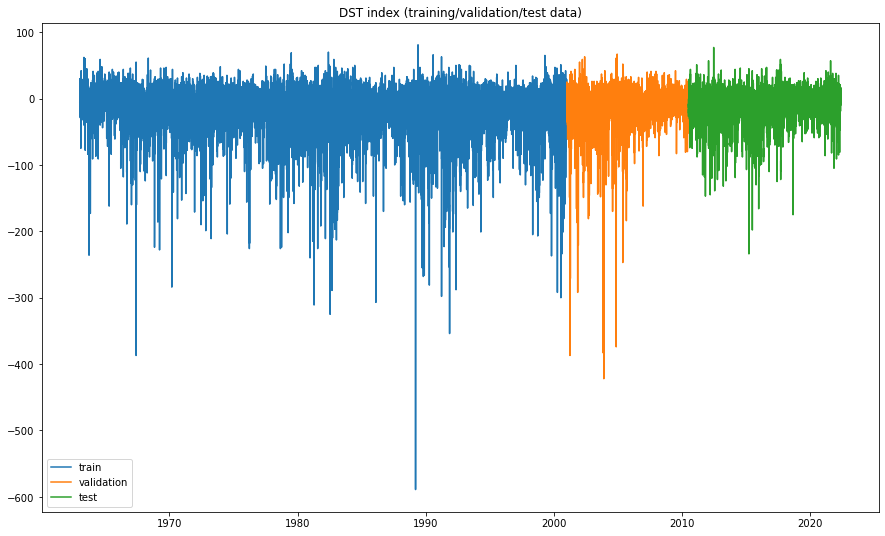

In [36]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [37]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [38]:
for i in range(len(test_generator)):
	x, y = test_generator[i]
	print('tt %s => %s' % (x, y))

tt [[-13. -12. -12. -17. -17. -15.]
 [-12. -12. -17. -17. -15. -11.]
 [-12. -17. -17. -15. -11.  -8.]
 ...
 [ -7.  -4.  -2.  -3.  -5.  -6.]
 [ -4.  -2.  -3.  -5.  -6.  -4.]
 [ -2.  -3.  -5.  -6.  -4.  -5.]] => [-15. -11.  -8. -12. -16. -14. -14. -14. -15. -17. -13. -15. -24. -21.
 -17. -15. -17. -25. -27. -26. -27. -27. -25. -26. -20. -16. -14. -14.
 -16. -16. -15. -13. -10. -15. -18. -21. -22. -18. -14. -15. -18. -19.
 -19. -16. -16. -17. -17. -15. -18. -15. -13. -12. -10. -14. -16. -16.
 -12. -10.  -9.  -9. -13. -17. -16. -21. -21. -19. -19. -17. -17. -19.
 -18. -19. -18. -16. -16. -16. -16. -14. -11.  -7.  -6. -11. -19. -22.
 -21. -18. -15. -13. -15. -13. -13. -12. -12.  -9. -10. -11. -14. -13.
 -12.  -8.  -4.  -1.  -1.  -1.  -4.  -6.  -9. -12. -12. -15. -19. -21.
 -18. -16. -12. -12. -11. -12. -15. -17. -17. -15. -14. -13.  -9.  -8.
  -9.  -9.  -8.  -5.  -3.  -5.  -7.  -9. -12. -10. -11. -12. -11.  -9.
  -9.  -8.  -9. -11. -10.  -8.  -3.  -3.  -3.   0.  -2.  -5.  -6.  -5.
  -6.  -6

In [39]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1302
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [40]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                             

In [41]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 256)           133120    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 7   

In [42]:
# callbacks
saved_model = "model_01.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [43]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
1301/1302 [============================>.] - ETA: 0s - loss: 76.3130 - mae: 2.9232
Epoch 1: val_mae improved from inf to 1.50988, saving model to model_01.hdf5
1302/1302 [==============================] - 57s 40ms/step - loss: 76.2585 - mae: 2.9220 - val_loss: 32.2983 - val_mae: 1.5099
Epoch 2/20
1302/1302 [==============================] - ETA: 0s - loss: 14.7540 - mae: 1.3612
Epoch 2: val_mae improved from 1.50988 to 0.99273, saving model to model_01.hdf5
1302/1302 [==============================] - 51s 39ms/step - loss: 14.7540 - mae: 1.3612 - val_loss: 13.9739 - val_mae: 0.9927
Epoch 3/20
1301/1302 [============================>.] - ETA: 0s - loss: 9.3197 - mae: 1.1599
Epoch 3: val_mae did not improve from 0.99273
1302/1302 [==============================] - 50s 39ms/step - loss: 9.3130 - mae: 1.1594 - val_loss: 7.6975 - val_mae: 1.1846
Epoch 4/20
1301/1302 [============================>.] - ETA: 0s - loss: 11.1285 - mae: 1.2423
Epoch 4: val_mae did not improve from 0.99

In [44]:
# load best model
model = keras.models.load_model('model_01.hdf5')

In [45]:
# prediction
y_pred = model.predict(test_generator)

407/407 [==============================] - 7s 15ms/step


In [46]:
y_pred

array([[-14.111336 ],
       [-10.503204 ],
       [ -7.8631935],
       ...,
       [  4.54574  ],
       [  5.6496954],
       [  5.5310946]], dtype=float32)

In [47]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[83363     3]
 [ 2621 18095]]


In [48]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     83366
           1       1.00      0.87      0.93     20716

    accuracy                           0.97    104082
   macro avg       0.98      0.94      0.96    104082
weighted avg       0.98      0.97      0.97    104082



In [49]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [50]:
df

,time,y_true,y_predict
416361,2010-06-29 11:00:00,-15.0,-14.111336
416362,2010-06-29 12:00:00,-11.0,-10.503204
416363,2010-06-29 13:00:00,-8.0,-7.863194
416364,2010-06-29 14:00:00,-12.0,-11.720310
416365,2010-06-29 15:00:00,-16.0,-15.244746
...,...,...,...
520438,2022-05-13 12:00:00,2.0,3.208302
520439,2022-05-13 13:00:00,2.0,2.704162
520440,2022-05-13 14:00:00,4.0,4.545740
520441,2022-05-13 15:00:00,5.0,5.649695


In [51]:
df.describe()

,y_true,y_predict
count,104082.000000,104082.000000
mean,-9.640918,-8.961142
std,16.040103,15.302522
min,-234.000000,-188.548843
25%,-17.000000,-15.866101
50%,-7.000000,-6.845496
75%,0.000000,0.567445
max,77.000000,52.933826


<AxesSubplot:>

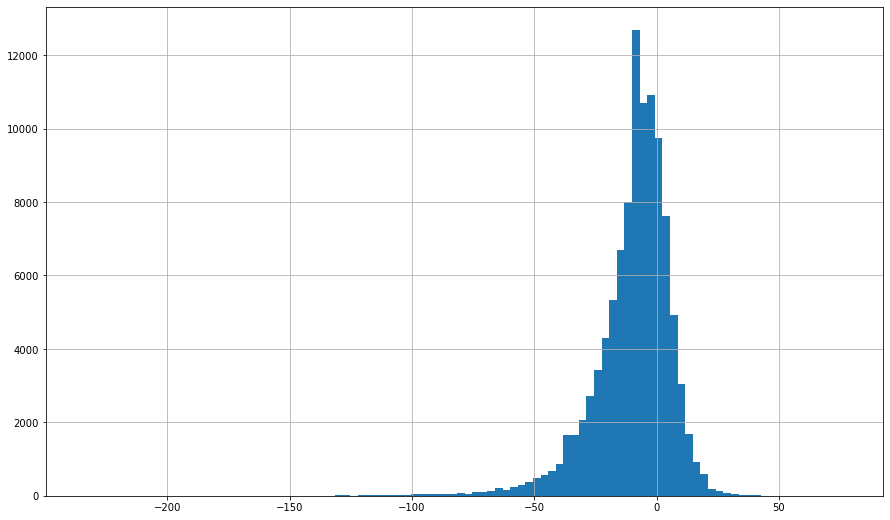

In [52]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

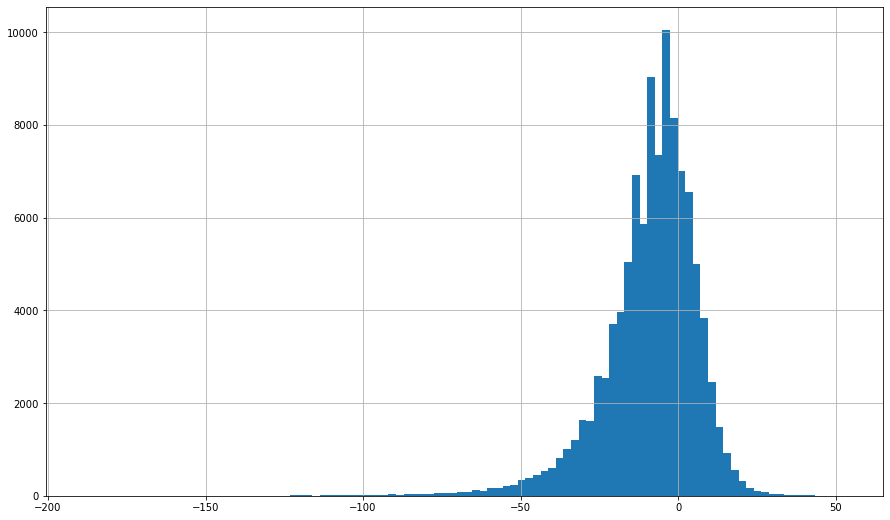

In [53]:
df["y_predict"].hist(bins=100)

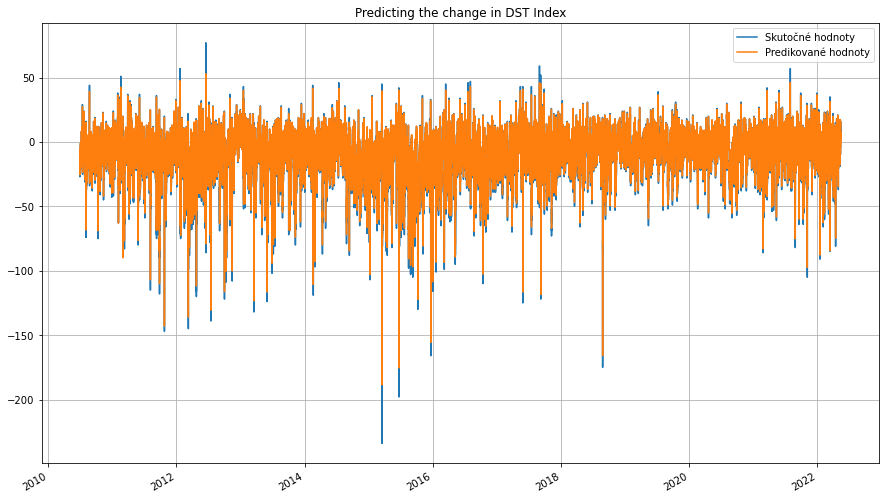

In [54]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [55]:
df.to_csv('predikcie_6h_dozadu_1h_dopredu.csv')